In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vPxoyS2EZGN1VywiWKHO")
project = rf.workspace("sliit-kuemd").project("cattle-diseases")
version = project.version(2)
dataset = version.download("folder")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.1

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cattle-diseases-2 in folder:: 100%|██████████| 855/855 [00:00<00:00, 2732.23it/s]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [2]:
 train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Random rotation within the range of [-20, 20] degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the height
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory('/content/cattle-diseases-2/train',
    batch_size=32,
    class_mode='binary',  # Change to categorical mode
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    '/content/cattle-diseases-2/valid',
    shuffle=False,
    class_mode='binary',  # Change to categorical mode
    target_size=(224,224))


Found 567 images belonging to 7 classes.
Found 186 images belonging to 7 classes.


In [3]:
conv_base = ResNet50(include_top=False,
                     weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(7, activation='softmax')(x)
model = Model(conv_base.input, predictions)

optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [6]:
model.fit(x = train_generator,
          validation_data = validation_generator,
          steps_per_epoch = 10,
          epochs=16)

Epoch 1/16
10/10 [==============================] - 8s 766ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 8.0586 - val_accuracy: 0.3925
Epoch 2/16
10/10 [==============================] - 7s 674ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 8.7853 - val_accuracy: 0.3925
Epoch 3/16
10/10 [==============================] - 6s 570ms/step - loss: 0.0061 - accuracy: 0.9969 - val_loss: 8.9324 - val_accuracy: 0.3925
Epoch 4/16
10/10 [==============================] - 6s 625ms/step - loss: 0.0071 - accuracy: 0.9968 - val_loss: 8.4532 - val_accuracy: 0.3925
Epoch 5/16
10/10 [==============================] - 7s 728ms/step - loss: 0.0110 - accuracy: 0.9937 - val_loss: 6.8533 - val_accuracy: 0.3978
Epoch 6/16
10/10 [==============================] - 6s 580ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 9.5242 - val_accuracy: 0.3871
Epoch 7/16
10/10 [==============================] - 6s 568ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 9.5405 - val_accuracy: 0.3978
Epoch 

In [7]:
# architecture and weights to HDF5
model.save('models/keras/model.h5')

# architecture to JSON, weights to HDF5
model.save_weights('models/keras/weights.h5')
with open('models/keras/architecture.json', 'w') as f:
    f.write(model.to_json())

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
# architecture and weights from HDF5
model = load_model('models/keras/model.h5')

# architecture from JSON, weights from HDF5
with open('models/keras/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('models/keras/weights.h5')

In [21]:
validation_img_paths = ["/content/cattle-diseases-2/test/healthy/Ayrshirecattle117_c_jpg.rf.9d4f40f05452ce9a5d7cd63f3dd32386.jpg",
                        "/content/cattle-diseases-2/test/lumpy skin/34_jpg.rf.7d232fda795d92e422dfb0846e192b85.jpg",
                        "/content/cattle-diseases-2/test/healthy/download-25-_jpg.rf.b6578236c25dd647fe7563b64714fffc.jpg",
                        "/content/cattle-diseases-2/test/lumpy skin/IMG-20220830-WA0084_jpg.rf.c332de559324110a097ef0c1a2d5edc4.jpg",
                        "/content/cattle-diseases-2/test/lumpy skin/IMG_20220830_081709_jpg.rf.674a1dd281c757ce12ff51a01d019181.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

1/1 [==============================] - 0s 37ms/step
[[1.7286381e-09 5.6392429e-11 5.2787748e-12 1.2667031e-08 7.3108741e-11
  1.0000000e+00 1.7138655e-08]
 [6.0699716e-07 2.8143575e-06 3.3441293e-07 3.5028283e-06 1.9210791e-05
  5.6364042e-06 9.9996793e-01]
 [1.6113809e-04 2.9609376e-08 1.3910948e-08 1.8354567e-05 1.5030568e-06
  9.9865603e-01 1.1628328e-03]
 [1.7156783e-07 8.4967724e-06 1.0337746e-07 1.5927364e-05 9.7255942e-08
  1.9050163e-05 9.9995613e-01]
 [2.9125155e-07 2.6704176e-05 1.7242613e-07 5.7329754e-07 1.3108915e-06
  9.0981189e-07 9.9996996e-01]]
BRD Disease Ecthym 1.0 5
Contagious Dermatits Lumpy skin 0.99996793 6
Dermatitis Ecthym Lumpy Skin 0.99865603 5
Ecthym Skin 0.99995613 6
Unlabeled 0.99996996 6


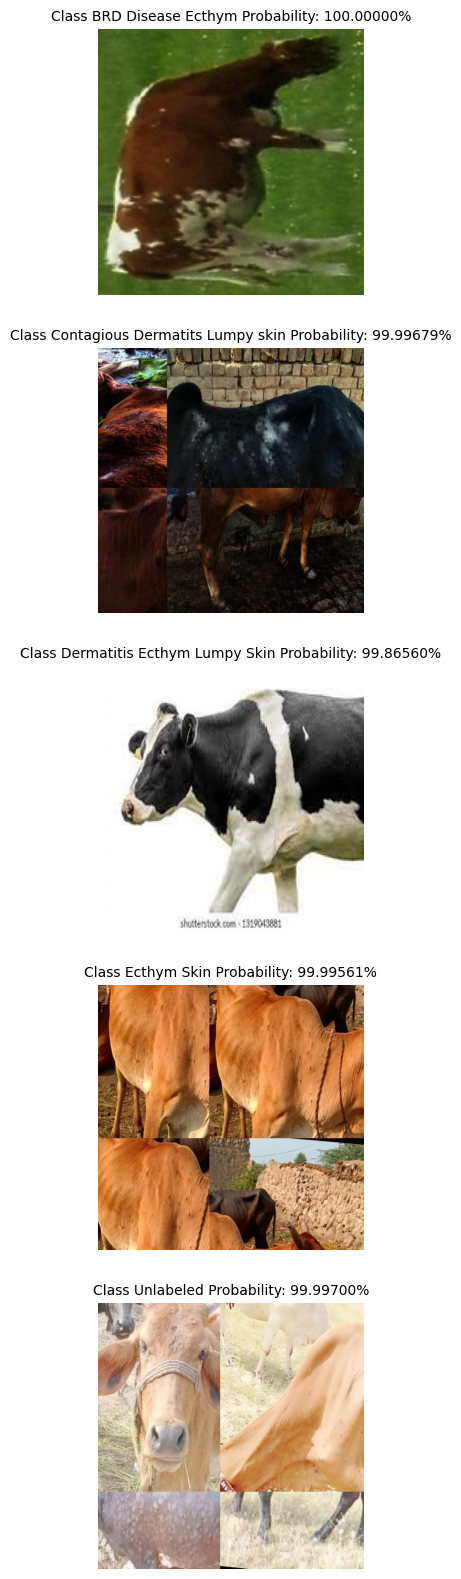

In [23]:
# Assuming model is already defined with appropriate architecture for 7 classes

img_size = 244

# Assuming img_list contains your images

validation_batch = np.stack([preprocess_input(np.array(img.resize((img_size, img_size))))
                             for img in img_list])

pred_probs = model.predict(validation_batch)

class_names = ['BRD Disease Ecthym', 'Contagious Dermatits Lumpy skin', 'Dermatitis Ecthym Lumpy Skin', 'Ecthym Skin', 'Unlabeled', 'Healthy', 'Lumpy Skin']

print(pred_probs)

length = len(pred_probs)
maxProbs = []
for i in range(length):
  max_value = max(pred_probs[i])
  max_index = np.argmax(pred_probs[i])

  print(class_names[i], max_value, max_index)
  maxProbs.append([max_value,max_index])

fig, axs = plt.subplots(5, 1, figsize=(12, 20))  # 3 rows, 5 columns
axs = axs.ravel()  # Flatten the axs array for easy indexing
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    class_probabilities = [100 * prob for prob in pred_probs[i]]
    ax.set_title("Class {} Probability: {:.5f}%".format(class_names[i] ,maxProbs[i][0] * 100), fontsize=10)
    ax.imshow(img)
